## Imports

In [2]:

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import cv2
from itertools import cycle
from numpy import genfromtxt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, accuracy_score
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

import graphviz 
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import SVG

from IPython.display import Image  

#----------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
#set image size
num_pixels = 24


In [3]:
# Importing training  data from CSV files
x_train_import = genfromtxt('x_train_gr_smpl.csv', delimiter=',', skip_header =1)
y_train_import = genfromtxt('y_train_smpl.csv', delimiter=',', skip_header =1 )

In [4]:
# Importing testing data from CSV files
x_test_import = genfromtxt('x_test_gr_smpl.csv', delimiter=',', skip_header =1)
y_test_import = genfromtxt('y_test_smpl.csv', delimiter=',', skip_header =1 )


In [5]:
# Normalisation of pixels
# x_train_import = x_train_import.astype('float')/255
# x_test_import  = x_test_import.astype('float')/255


In [6]:
# Check data has been imported correctly 
print(x_train_import.shape)
print(y_train_import.shape)
print(x_test_import.shape)
print(y_test_import.shape)

(12660, 2304)
(12660,)
(4170, 2304)
(4170,)


## Preprocessing

In [7]:
# Combinging data with labels

y_train_import = y_train_import.reshape(12660,1)
train_data_combined = np.append(x_train_import, y_train_import, axis=1)

y_test_import = y_test_import.reshape(4170,1)
test_data_combined = np.append(x_test_import, y_test_import, axis=1)


In [8]:
# Randomises row order in a reproducable way 
np.random.seed(0)
np.random.shuffle(train_data_combined)
np.random.shuffle(test_data_combined)

In [9]:
#equalize the data so all classes have the same amount of instances - not used as we found it better to use all data - see report

def equilize(data):
    train_combined_equal = []
    for x in range(10):
        count = 0
        #while count < 2000:
        for i in data :
            if i[-1] == x and count < 4000: #can limit max number of instances in each class 
                train_combined_equal.append(i)
                count += 1
        
    train_combined_equal = np.asarray(train_combined_equal)
    np.random.shuffle(train_combined_equal)      
    
    return train_combined_equal

train_combined_equal = equilize(train_data_combined)
print("length:",len(train_combined_equal))

length: 12660


In [10]:
# Split data and lables that have undergone the same randomization process
# x_train = train_combined_equal[:,:-1]
# y_train = train_combined_equal[:, [-1]].reshape(2400,)   
x_train = train_combined_equal[:,:-1]
y_train = train_combined_equal[:, [-1]].reshape(len(train_combined_equal),)   


x_train_all = train_data_combined[:,:-1]
y_train_all = train_data_combined[:, [-1]].reshape(12660,)

x_test = test_data_combined[:,:-1]
y_test = test_data_combined[:, [-1]].reshape(4170,)

#what is the mean of the data
print("train mean:",np.mean(x_train))
print("test mean:",np.mean(x_test))
#shows that test set has been ofset

train mean: 80.957739030685
test mean: 85.48841426858513


In [11]:
#  Reducing the number of attributes using opencv's reduce functionality as shown in the second python Lecture
#  As seen in python lectures: https://vision.hw.ac.uk/webapps/blackboard/content/listContent.jsp?course_id=_94419_1&content_id=_3391865_1
x_train_all = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_train_all).reshape((-1,num_pixels*num_pixels))

x_train = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_train).reshape((-1,num_pixels*num_pixels))

x_test  = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_test).reshape((-1,num_pixels*num_pixels))

#### Data for Q6 and Q7

In [12]:
#split data for q6 - 30% from train to test
x_train_q6, x_test_q6, y_train_q6, y_test_q6 = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)
#combine test sets
x_test_q6 = np.append(x_test_q6,x_test, axis=0)
y_test_q6 = np.append(y_test_q6,y_test, axis=0)
#split data for q7 - 70% from train to test
x_train_q7, x_test_q7, y_train_q7, y_test_q7 = train_test_split(x_train, y_train, test_size=0.7, stratify=y_train)
#combine test sets
x_test_q7 = np.append(x_test_q7,x_test, axis=0)
y_test_q7 = np.append(y_test_q7,y_test, axis=0)
print("Test data:",x_test.shape)
print("Test data q6:",x_test_q6.shape)
print("Test data q7:",x_test_q7.shape)

print("Train data:",x_train.shape)
print("Train data q6:",x_train_q6.shape)
print("Train data q7:",x_train_q7.shape)

Test data: (4170, 576)
Test data q6: (7968, 576)
Test data q7: (13032, 576)
Train data: (12660, 576)
Train data q6: (8862, 576)
Train data q7: (3798, 576)


In [13]:
x_train_test = np.append(x_train,x_test, axis=0)
y_train_test = np.append(y_train,y_test, axis=0)

#### standardise data for test

In [14]:
#create a standardise method to standardise images in data sets
def standardise2(data):
    x_train_norm = []
    for row in data:
        rownew = []
        mean = np.mean(row)

        sd = np.std(row)
        #print(row)
        for i in row:
            j = (i - mean)/sd
            rownew.append(j)
        x_train_norm.append(rownew)
    x_train_norm = np.asarray(x_train_norm)    
    return(x_train_norm)

    
x_train_stan = standardise2(x_train)
x_test_stan = standardise2(x_test)
#check not messed up
print("train shape:",x_train_stan.shape)
print("test shape:",x_test_stan.shape)

train shape: (12660, 576)
test shape: (4170, 576)


### calculating FP, TP, FPR, TPR

In [15]:
# method that returns the true positive(TP)-false positive(FP) & true positive rate(TR)-false positive rate(FR)
def perf_measure(y_actual, y_pred):
    TP = [0,0,0,0,0,0,0,0,0,0]
    FP = [0,0,0,0,0,0,0,0,0,0]
    TN = [0,0,0,0,0,0,0,0,0,0]
    FN = [0,0,0,0,0,0,0,0,0,0]
    TR = [0,0,0,0,0,0,0,0,0,0]
    FR = [0,0,0,0,0,0,0,0,0,0]
    for j in range(10):
        for i in range(len(y_pred)): 
            if y_actual[i]==y_pred[i]==j:
               TP[j] += 1
            if y_pred[i]==j and y_actual[i]!=y_pred[i]:
               FP[j] += 1   
            if y_actual[i]!=j and y_pred[i]!=j:
               TN[j] += 1
            if y_actual[i]==j and y_actual[i]!=y_pred[i]:
               FN[j] += 1
        TR[j] += round((TP[j]*100)/(TP[j]+FN[j]), 2)
        FR[j] += round((FP[j]*100)/(FP[j]+TN[j]), 2)
    ret = '   TP - FP        TR - FR \n'
    for x in range(10):
        ret  += str(x) + ' ' +str(TP[x]) + '-' + str(FP[x])+ '      ' +str(TR[x])+ '-' +str(FR[x])+ '\n'

    return(ret)

## Ten Fold Cross Validation


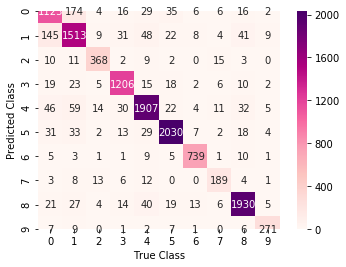

In [16]:
#ten fold on train data
clf = tree.DecisionTreeClassifier(class_weight = "balanced")
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
conf_mat = confusion_matrix(y_train, y_pred)
#confusion matrix
sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
plt.xlabel('True Class')
plt.ylabel('Predicted Class');

In [17]:
print(classification_report(y_train, y_pred))
print(perf_measure(y_train, y_pred))


              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80      1410
         1.0       0.83      0.81      0.82      1860
         2.0       0.88      0.88      0.88       420
         3.0       0.92      0.91      0.92      1320
         4.0       0.90      0.91      0.90      2100
         5.0       0.94      0.94      0.94      2160
         6.0       0.95      0.95      0.95       780
         7.0       0.80      0.79      0.79       240
         8.0       0.93      0.93      0.93      2070
         9.0       0.89      0.90      0.90       300

    accuracy                           0.89     12660
   macro avg       0.88      0.88      0.88     12660
weighted avg       0.89      0.89      0.89     12660

   TP - FP        TR - FR 
0 1123-288      79.65-2.56
1 1513-317      81.34-2.94
2 368-52      87.62-0.42
3 1206-100      91.36-0.88
4 1907-223      90.81-2.11
5 2030-139      93.98-1.32
6 739-36      94.74-0.3
7 189-47      78.75-0.38
8 193

## Test overfitting - j48 equivilent

In [18]:
#try standared tree with no limits 
clf = tree.DecisionTreeClassifier(class_weight = "balanced")

#clf.fit(x_train, y_train)
y_score = clf.fit(x_train,y_train).predict_proba(x_test)
graph = graphviz.Source(tree.export_graphviz(clf, out_file=None,filled=True,rounded=True,class_names=True))  
png_bytes = graph.pipe(format='png')  
name = "overfitting_base_tree.png"
with open(name,'wb') as f:
    f.write(png_bytes)

#Image(name)



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.223722 to fit


              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57       450
         1.0       0.59      0.68      0.63       630
         2.0       0.62      0.37      0.47       150
         3.0       0.84      0.80      0.82       420
         4.0       0.76      0.81      0.79       690
         5.0       0.86      0.93      0.89       720
         6.0       0.80      0.74      0.77       270
         7.0       0.09      0.10      0.09        60
         8.0       0.81      0.82      0.82       690
         9.0       0.67      0.42      0.52        90

    accuracy                           0.74      4170
   macro avg       0.67      0.62      0.64      4170
weighted avg       0.74      0.74      0.74      4170



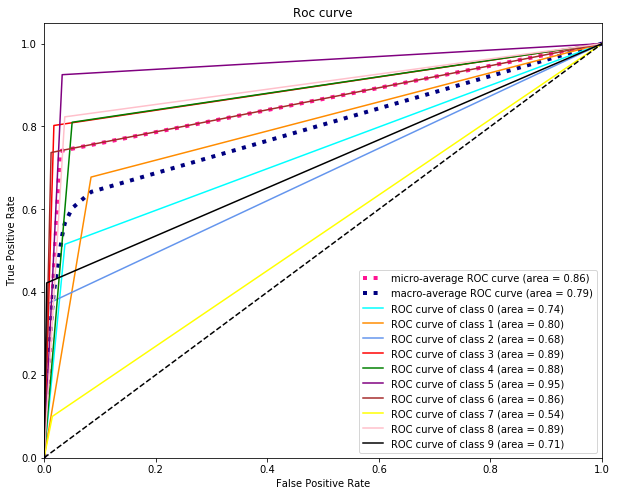

In [19]:
# graph = graphviz.Source(dot_data) 
# graph.render("overfitting_tree") 
#predict on test set
y_pred_test_data = clf.predict(x_test)
print(classification_report(y_test, y_pred_test_data))
rocCurve(y_test, y_score)

In [20]:
#now predict on training set - will be alot better than predictions on test - shows overfitting
y_pred_train_data = clf.predict(x_train)
print(classification_report(y_train, y_pred_train_data))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1410
         1.0       1.00      1.00      1.00      1860
         2.0       1.00      1.00      1.00       420
         3.0       1.00      1.00      1.00      1320
         4.0       1.00      1.00      1.00      2100
         5.0       1.00      1.00      1.00      2160
         6.0       1.00      1.00      1.00       780
         7.0       1.00      1.00      1.00       240
         8.0       1.00      1.00      1.00      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           1.00     12660
   macro avg       1.00      1.00      1.00     12660
weighted avg       1.00      1.00      1.00     12660



#### limit fitting

##### using min_samples_split

In [21]:
#try and limit overfitting a different way
# using min_samples_split

#loop through and try different values
clf_list = []
split = (0.02, 0.015, 0.01, 0.008, 0.006, 0.004,0.002, 0.001)
for x in split:
    clf_smpl_splt = tree.DecisionTreeClassifier(class_weight = "balanced",min_samples_split = x)
    clf_smpl_splt.fit(x_train, y_train)
    graph = graphviz.Source(tree.export_graphviz(clf_smpl_splt, out_file=None,filled=True,rounded=True,class_names=True)) 
    clf_list.append( clf_smpl_splt)
    
    png_bytes = graph.pipe(format='png')  
    name = "overfitting_tree_"+str(x)+ ".png"
    with open(name,'wb') as f:
        f.write(png_bytes)
    


#Image("overfitting_tree_"+str(0.001)+ ".png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.979289 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.894589 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.751985 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.597654 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.437126 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.363605 to fit



 
 

next model, with split = 0.02
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.46      0.53       450
         1.0       0.56      0.61      0.59       630
         2.0       0.61      0.57      0.59       150
         3.0       0.64      0.78      0.70       420
         4.0       0.69      0.59      0.64       690
         5.0       0.88      0.80      0.84       720
         6.0       0.76      0.53      0.63       270
         7.0       0.01      0.02      0.01        60
         8.0       0.69      0.69      0.69       690
         9.0       0.17      0.53      0.26        90

    accuracy                           0.64      4170
   macro avg       0.56      0.56      0.55      4170
weighted avg       0.67      0.64      0.65      4170



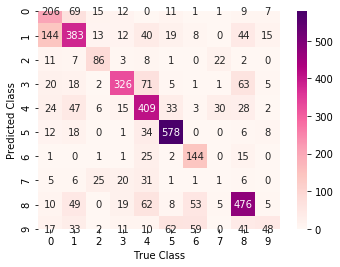

on train:
               precision    recall  f1-score   support

         0.0       0.71      0.69      0.70      1410
         1.0       0.70      0.69      0.69      1860
         2.0       0.69      0.89      0.77       420
         3.0       0.75      0.89      0.81      1320
         4.0       0.84      0.70      0.76      2100
         5.0       0.93      0.77      0.84      2160
         6.0       0.81      0.87      0.84       780
         7.0       0.63      0.88      0.73       240
         8.0       0.83      0.77      0.80      2070
         9.0       0.40      0.96      0.56       300

    accuracy                           0.77     12660
   macro avg       0.73      0.81      0.75     12660
weighted avg       0.79      0.77      0.77     12660


 
 

next model, with split = 0.015
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.50      0.55       450
         1.0       0.61      0.63      0.62       630
         2.0       0

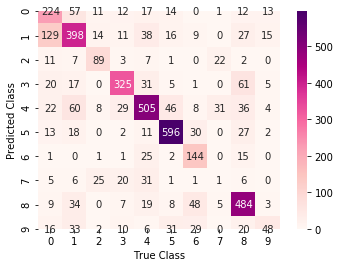

on train:
               precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      1410
         1.0       0.82      0.71      0.76      1860
         2.0       0.71      0.92      0.80       420
         3.0       0.83      0.88      0.85      1320
         4.0       0.83      0.81      0.82      2100
         5.0       0.93      0.80      0.86      2160
         6.0       0.81      0.87      0.84       780
         7.0       0.63      0.88      0.73       240
         8.0       0.86      0.81      0.83      2070
         9.0       0.54      0.96      0.69       300

    accuracy                           0.81     12660
   macro avg       0.77      0.84      0.79     12660
weighted avg       0.82      0.81      0.81     12660


 
 

next model, with split = 0.01
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.53      0.57       450
         1.0       0.60      0.64      0.62       630
         2.0       0.

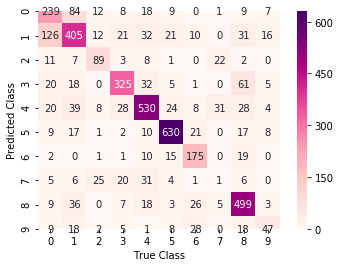

on train:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.77      1410
         1.0       0.82      0.75      0.78      1860
         2.0       0.71      0.92      0.80       420
         3.0       0.83      0.88      0.85      1320
         4.0       0.88      0.83      0.85      2100
         5.0       0.96      0.86      0.91      2160
         6.0       0.82      0.94      0.88       780
         7.0       0.61      0.88      0.72       240
         8.0       0.91      0.84      0.88      2070
         9.0       0.70      0.97      0.81       300

    accuracy                           0.84     12660
   macro avg       0.80      0.87      0.83     12660
weighted avg       0.85      0.84      0.84     12660


 
 

next model, with split = 0.008
on test:
               precision    recall  f1-score   support

         0.0       0.58      0.54      0.56       450
         1.0       0.62      0.61      0.61       630
         2.0       0

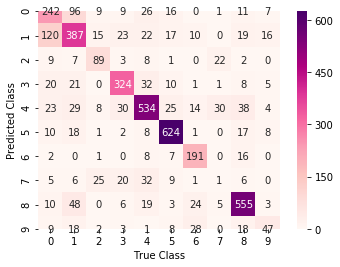

on train:
               precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      1410
         1.0       0.84      0.75      0.79      1860
         2.0       0.73      0.92      0.82       420
         3.0       0.84      0.90      0.87      1320
         4.0       0.89      0.86      0.87      2100
         5.0       0.97      0.86      0.91      2160
         6.0       0.88      0.95      0.91       780
         7.0       0.61      0.90      0.73       240
         8.0       0.92      0.87      0.89      2070
         9.0       0.71      0.97      0.82       300

    accuracy                           0.86     12660
   macro avg       0.82      0.88      0.84     12660
weighted avg       0.87      0.86      0.86     12660


 
 

next model, with split = 0.006
on test:
               precision    recall  f1-score   support

         0.0       0.59      0.52      0.56       450
         1.0       0.61      0.64      0.63       630
         2.0       0

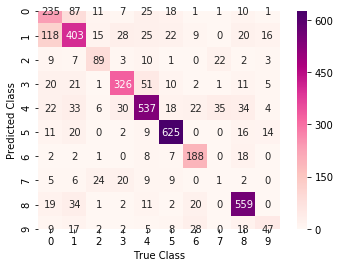

on train:
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1410
         1.0       0.85      0.80      0.82      1860
         2.0       0.72      0.96      0.83       420
         3.0       0.87      0.90      0.89      1320
         4.0       0.91      0.89      0.90      2100
         5.0       0.98      0.89      0.93      2160
         6.0       0.88      0.95      0.91       780
         7.0       0.70      0.90      0.79       240
         8.0       0.97      0.89      0.93      2070
         9.0       0.69      0.97      0.81       300

    accuracy                           0.88     12660
   macro avg       0.84      0.90      0.86     12660
weighted avg       0.89      0.88      0.88     12660


 
 

next model, with split = 0.004
on test:
               precision    recall  f1-score   support

         0.0       0.60      0.54      0.57       450
         1.0       0.56      0.64      0.60       630
         2.0       0

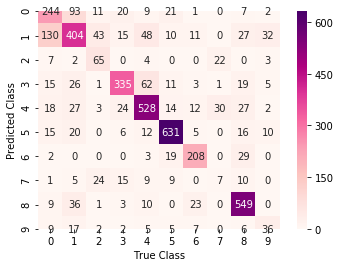

on train:
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1410
         1.0       0.88      0.86      0.87      1860
         2.0       0.88      0.97      0.92       420
         3.0       0.87      0.93      0.90      1320
         4.0       0.94      0.92      0.93      2100
         5.0       0.97      0.90      0.94      2160
         6.0       0.90      0.97      0.93       780
         7.0       0.79      0.93      0.86       240
         8.0       0.98      0.91      0.95      2070
         9.0       0.78      0.98      0.87       300

    accuracy                           0.91     12660
   macro avg       0.88      0.93      0.90     12660
weighted avg       0.91      0.91      0.91     12660


 
 

next model, with split = 0.002
on test:
               precision    recall  f1-score   support

         0.0       0.58      0.53      0.55       450
         1.0       0.59      0.65      0.62       630
         2.0       0

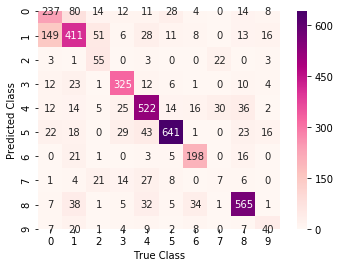

on train:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      1410
         1.0       0.95      0.91      0.93      1860
         2.0       0.96      0.98      0.97       420
         3.0       0.96      0.95      0.95      1320
         4.0       0.97      0.94      0.96      2100
         5.0       0.97      0.95      0.96      2160
         6.0       0.96      0.98      0.97       780
         7.0       0.81      0.98      0.89       240
         8.0       0.98      0.95      0.96      2070
         9.0       0.82      0.99      0.90       300

    accuracy                           0.95     12660
   macro avg       0.92      0.96      0.94     12660
weighted avg       0.95      0.95      0.95     12660


 
 

next model, with split = 0.001
on test:
               precision    recall  f1-score   support

         0.0       0.57      0.50      0.53       450
         1.0       0.60      0.65      0.62       630
         2.0       0

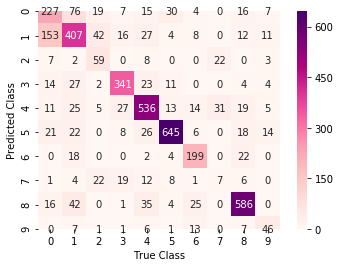

on train:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      1410
         1.0       0.97      0.94      0.96      1860
         2.0       0.95      0.99      0.97       420
         3.0       0.96      0.97      0.96      1320
         4.0       0.98      0.96      0.97      2100
         5.0       0.98      0.96      0.97      2160
         6.0       0.97      0.98      0.98       780
         7.0       0.82      0.99      0.90       240
         8.0       0.99      0.98      0.98      2070
         9.0       0.96      1.00      0.98       300

    accuracy                           0.97     12660
   macro avg       0.95      0.97      0.96     12660
weighted avg       0.97      0.97      0.97     12660



In [22]:
i = 0
for clf_smpl_splt in clf_list:
    #predict on test and training data again
    y_pred_test_data_splt = clf_smpl_splt.predict(x_test)
    y_pred_train_data_splt = clf_smpl_splt.predict(x_train)
    # results on test close to results without limit
    print("\n \n \n")
    print("next model, with split =",split[i])
    print("on test:\n",classification_report(y_test, y_pred_test_data_splt))
    conf_mat = confusion_matrix(y_test, y_pred_test_data_splt)
    sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class');
    plt.show()
    #shows overfitting
    print("on train:\n",classification_report(y_train, y_pred_train_data_splt))
    i +=1

##### using max_depth

In [23]:
#try and limit overfitting a different way
# using max depth

#loop through and try different values
clf_list2 = []
for x in range(5,16):#below five layes terrible results so dont show
    clf_smpl_splt = tree.DecisionTreeClassifier(class_weight = "balanced", max_depth = x)
    clf_smpl_splt.fit(x_train, y_train)
    graph = graphviz.Source(tree.export_graphviz(clf_smpl_splt, out_file=None,filled=True,rounded=True,class_names=True)) 
    clf_list2.append( clf_smpl_splt)
    
    png_bytes = graph.pipe(format='png')  
    name = "overfitting_tree_depth_"+str(x)+ ".png"
    with open(name,'wb') as f:
        f.write(png_bytes)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692587 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.470054 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.343311 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.286984 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.255423 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.238566 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.2299 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.228051 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.226606 to fit



 
 

next model, with depth: 5
on test:
               precision    recall  f1-score   support

         0.0       0.30      0.64      0.41       450
         1.0       0.52      0.08      0.14       630
         2.0       0.42      0.13      0.20       150
         3.0       0.91      0.76      0.83       420
         4.0       0.36      0.55      0.44       690
         5.0       0.85      0.63      0.72       720
         6.0       0.75      0.44      0.55       270
         7.0       0.01      0.02      0.01        60
         8.0       0.44      0.46      0.45       690
         9.0       0.11      0.08      0.09        90

    accuracy                           0.47      4170
   macro avg       0.47      0.38      0.38      4170
weighted avg       0.55      0.47      0.47      4170



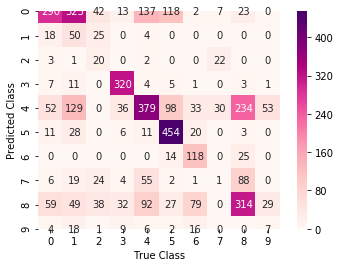

on train:
               precision    recall  f1-score   support

         0.0       0.33      0.71      0.45      1410
         1.0       0.84      0.20      0.32      1860
         2.0       0.74      0.62      0.67       420
         3.0       0.93      0.73      0.82      1320
         4.0       0.44      0.57      0.50      2100
         5.0       0.88      0.44      0.58      2160
         6.0       0.95      0.62      0.75       780
         7.0       0.30      0.63      0.41       240
         8.0       0.45      0.59      0.51      2070
         9.0       0.69      0.65      0.67       300

    accuracy                           0.54     12660
   macro avg       0.66      0.58      0.57     12660
weighted avg       0.66      0.54      0.54     12660


 
 

next model, with depth: 6
on test:
               precision    recall  f1-score   support

         0.0       0.47      0.52      0.49       450
         1.0       0.40      0.19      0.26       630
         2.0       0.21  

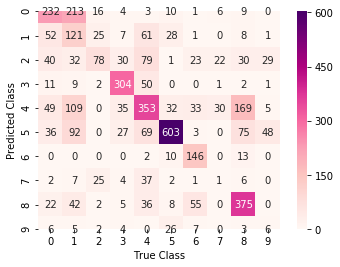

on train:
               precision    recall  f1-score   support

         0.0       0.54      0.61      0.57      1410
         1.0       0.56      0.34      0.43      1860
         2.0       0.23      0.86      0.37       420
         3.0       0.86      0.77      0.81      1320
         4.0       0.58      0.57      0.58      2100
         5.0       0.72      0.77      0.74      2160
         6.0       0.97      0.64      0.77       780
         7.0       0.56      0.67      0.61       240
         8.0       0.75      0.62      0.68      2070
         9.0       0.66      0.75      0.70       300

    accuracy                           0.62     12660
   macro avg       0.64      0.66      0.63     12660
weighted avg       0.67      0.62      0.63     12660


 
 

next model, with depth: 7
on test:
               precision    recall  f1-score   support

         0.0       0.46      0.50      0.47       450
         1.0       0.53      0.51      0.52       630
         2.0       0.31  

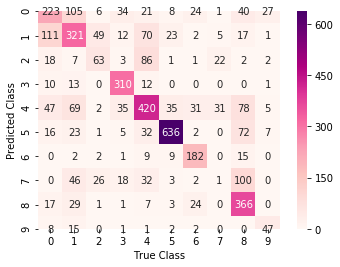

on train:
               precision    recall  f1-score   support

         0.0       0.52      0.71      0.60      1410
         1.0       0.60      0.60      0.60      1860
         2.0       0.47      0.93      0.63       420
         3.0       0.97      0.78      0.86      1320
         4.0       0.69      0.66      0.67      2100
         5.0       0.92      0.85      0.88      2160
         6.0       0.84      0.72      0.77       780
         7.0       0.35      0.80      0.48       240
         8.0       0.89      0.63      0.74      2070
         9.0       0.88      0.96      0.92       300

    accuracy                           0.72     12660
   macro avg       0.71      0.76      0.72     12660
weighted avg       0.76      0.72      0.73     12660


 
 

next model, with depth: 8
on test:
               precision    recall  f1-score   support

         0.0       0.50      0.53      0.51       450
         1.0       0.54      0.57      0.55       630
         2.0       0.61  

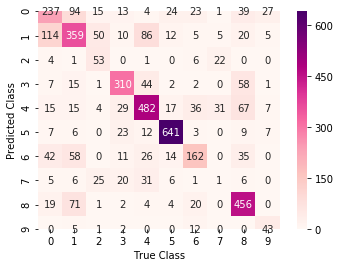

on train:
               precision    recall  f1-score   support

         0.0       0.58      0.76      0.66      1410
         1.0       0.69      0.68      0.68      1860
         2.0       0.89      0.93      0.91       420
         3.0       0.90      0.85      0.87      1320
         4.0       0.81      0.81      0.81      2100
         5.0       0.98      0.87      0.92      2160
         6.0       0.72      0.90      0.80       780
         7.0       0.66      0.95      0.77       240
         8.0       0.93      0.75      0.83      2070
         9.0       0.98      0.96      0.97       300

    accuracy                           0.81     12660
   macro avg       0.81      0.85      0.82     12660
weighted avg       0.82      0.81      0.81     12660


 
 

next model, with depth: 9
on test:
               precision    recall  f1-score   support

         0.0       0.54      0.56      0.55       450
         1.0       0.58      0.69      0.63       630
         2.0       0.65  

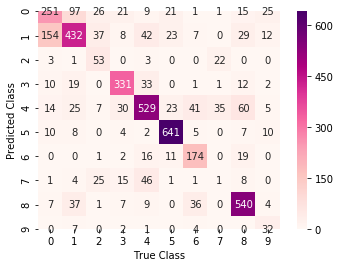

on train:
               precision    recall  f1-score   support

         0.0       0.65      0.84      0.74      1410
         1.0       0.77      0.75      0.76      1860
         2.0       0.95      0.96      0.96       420
         3.0       0.94      0.92      0.93      1320
         4.0       0.85      0.88      0.87      2100
         5.0       0.99      0.88      0.93      2160
         6.0       0.94      0.93      0.93       780
         7.0       0.75      0.95      0.84       240
         8.0       0.94      0.84      0.88      2070
         9.0       0.99      0.96      0.98       300

    accuracy                           0.86     12660
   macro avg       0.88      0.89      0.88     12660
weighted avg       0.87      0.86      0.87     12660


 
 

next model, with depth: 10
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.52      0.57       450
         1.0       0.59      0.73      0.65       630
         2.0       0.66 

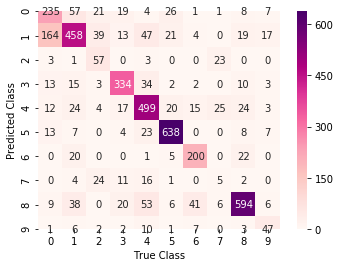

on train:
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1410
         1.0       0.80      0.89      0.84      1860
         2.0       0.97      0.97      0.97       420
         3.0       0.98      0.94      0.96      1320
         4.0       0.94      0.88      0.91      2100
         5.0       1.00      0.89      0.94      2160
         6.0       0.96      0.98      0.97       780
         7.0       0.89      0.97      0.93       240
         8.0       0.88      0.93      0.90      2070
         9.0       0.89      0.98      0.93       300

    accuracy                           0.91     12660
   macro avg       0.92      0.93      0.92     12660
weighted avg       0.91      0.91      0.91     12660


 
 

next model, with depth: 11
on test:
               precision    recall  f1-score   support

         0.0       0.65      0.54      0.59       450
         1.0       0.59      0.71      0.64       630
         2.0       0.61 

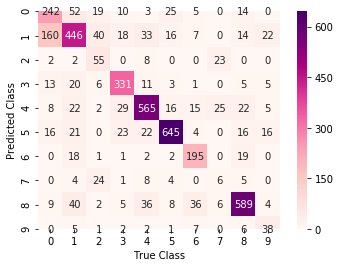

on train:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      1410
         1.0       0.86      0.92      0.89      1860
         2.0       0.98      0.99      0.98       420
         3.0       0.96      0.97      0.97      1320
         4.0       0.96      0.94      0.95      2100
         5.0       0.99      0.92      0.96      2160
         6.0       1.00      0.99      0.99       780
         7.0       0.90      0.99      0.95       240
         8.0       0.95      0.96      0.95      2070
         9.0       0.99      0.98      0.98       300

    accuracy                           0.94     12660
   macro avg       0.95      0.96      0.95     12660
weighted avg       0.94      0.94      0.94     12660


 
 

next model, with depth: 12
on test:
               precision    recall  f1-score   support

         0.0       0.63      0.52      0.57       450
         1.0       0.61      0.68      0.64       630
         2.0       0.59 

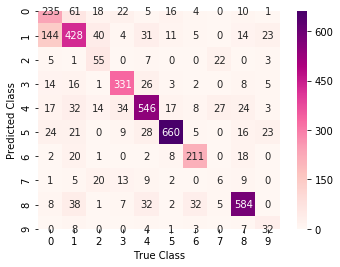

on train:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1410
         1.0       0.93      0.94      0.93      1860
         2.0       0.98      0.99      0.98       420
         3.0       0.98      0.98      0.98      1320
         4.0       0.96      0.97      0.96      2100
         5.0       0.99      0.94      0.97      2160
         6.0       0.95      1.00      0.97       780
         7.0       0.99      0.99      0.99       240
         8.0       0.98      0.98      0.98      2070
         9.0       0.98      0.99      0.98       300

    accuracy                           0.96     12660
   macro avg       0.97      0.97      0.97     12660
weighted avg       0.96      0.96      0.96     12660


 
 

next model, with depth: 13
on test:
               precision    recall  f1-score   support

         0.0       0.61      0.52      0.56       450
         1.0       0.60      0.69      0.64       630
         2.0       0.63 

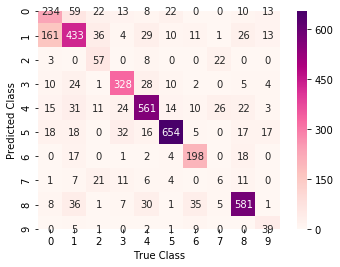

on train:
               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      1410
         1.0       0.96      0.97      0.96      1860
         2.0       0.99      0.99      0.99       420
         3.0       0.99      1.00      0.99      1320
         4.0       0.97      0.98      0.97      2100
         5.0       1.00      0.95      0.98      2160
         6.0       1.00      1.00      1.00       780
         7.0       0.98      1.00      0.99       240
         8.0       0.99      0.98      0.99      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           0.98     12660
   macro avg       0.98      0.98      0.98     12660
weighted avg       0.98      0.98      0.98     12660


 
 

next model, with depth: 14
on test:
               precision    recall  f1-score   support

         0.0       0.57      0.49      0.53       450
         1.0       0.60      0.68      0.64       630
         2.0       0.64 

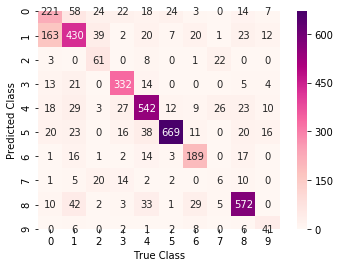

on train:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      1410
         1.0       0.99      0.97      0.98      1860
         2.0       0.99      1.00      1.00       420
         3.0       1.00      1.00      1.00      1320
         4.0       0.98      0.99      0.98      2100
         5.0       0.99      0.99      0.99      2160
         6.0       1.00      1.00      1.00       780
         7.0       1.00      1.00      1.00       240
         8.0       1.00      0.99      0.99      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           0.99     12660
   macro avg       0.99      0.99      0.99     12660
weighted avg       0.99      0.99      0.99     12660


 
 

next model, with depth: 15
on test:
               precision    recall  f1-score   support

         0.0       0.59      0.50      0.54       450
         1.0       0.63      0.67      0.65       630
         2.0       0.61 

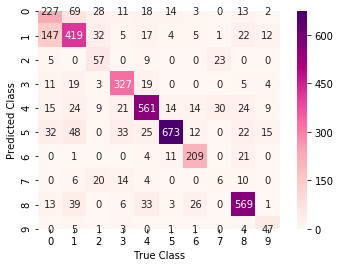

on train:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1410
         1.0       1.00      0.99      0.99      1860
         2.0       1.00      1.00      1.00       420
         3.0       1.00      1.00      1.00      1320
         4.0       1.00      0.99      0.99      2100
         5.0       0.99      1.00      0.99      2160
         6.0       1.00      1.00      1.00       780
         7.0       1.00      1.00      1.00       240
         8.0       1.00      0.99      0.99      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           0.99     12660
   macro avg       1.00      1.00      1.00     12660
weighted avg       0.99      0.99      0.99     12660



In [24]:
i = 5
for clf_smpl_splt in clf_list2:
    #predict on test and training data again
    y_pred_test_data_splt = clf_smpl_splt.predict(x_test)
    y_pred_train_data_splt = clf_smpl_splt.predict(x_train)
    # results on test close to results without limit
    print("\n \n \n")
    print("next model, with depth:",i)
    print("on test:\n",classification_report(y_test, y_pred_test_data_splt))
    conf_mat = confusion_matrix(y_test, y_pred_test_data_splt)
    sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class');
    plt.show()
    #shows overfitting
    print("on train:\n",classification_report(y_train, y_pred_train_data_splt))
    i +=1

##### using min_samples_leaf

In [25]:
#try and limit overfitting a different way
# using min_samples_leaf

#loop through and try different values
clf_list3= []

for x in range(1,21,2):
    clf_smpl_splt = tree.DecisionTreeClassifier(class_weight = "balanced",min_samples_leaf = x)
    clf_smpl_splt.fit(x_train, y_train)
    graph = graphviz.Source(tree.export_graphviz(clf_smpl_splt, out_file=None,filled=True,rounded=True,class_names=True)) 
    clf_list3.append( clf_smpl_splt)
    
    png_bytes = graph.pipe(format='png')  
    name = "overfitting_tree_minleaf_"+str(x)+ ".png"
    with open(name,'wb') as f:
        f.write(png_bytes)
    


#Image("overfitting_tree_minleaf_"+str(1)+ ".png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.22279 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.288351 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.3433 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.372903 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.411915 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.432516 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.453441 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.502654 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.532961 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.554142 to fit



 
 

next model, with min node = 1
on test:
               precision    recall  f1-score   support

         0.0       0.57      0.51      0.54       450
         1.0       0.60      0.68      0.64       630
         2.0       0.67      0.40      0.50       150
         3.0       0.84      0.78      0.81       420
         4.0       0.77      0.79      0.78       690
         5.0       0.83      0.93      0.88       720
         6.0       0.90      0.78      0.84       270
         7.0       0.08      0.10      0.09        60
         8.0       0.84      0.84      0.84       690
         9.0       0.72      0.48      0.57        90

    accuracy                           0.74      4170
   macro avg       0.68      0.63      0.65      4170
weighted avg       0.74      0.74      0.74      4170



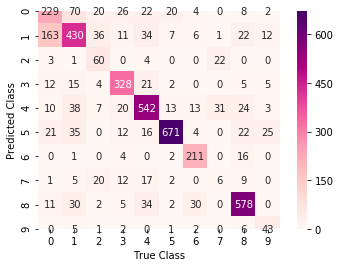

on train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1410
         1.0       1.00      1.00      1.00      1860
         2.0       1.00      1.00      1.00       420
         3.0       1.00      1.00      1.00      1320
         4.0       1.00      1.00      1.00      2100
         5.0       1.00      1.00      1.00      2160
         6.0       1.00      1.00      1.00       780
         7.0       1.00      1.00      1.00       240
         8.0       1.00      1.00      1.00      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           1.00     12660
   macro avg       1.00      1.00      1.00     12660
weighted avg       1.00      1.00      1.00     12660


 
 

next model, with min node = 3
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.53      0.57       450
         1.0       0.63      0.67      0.65       630
         2.0       0.

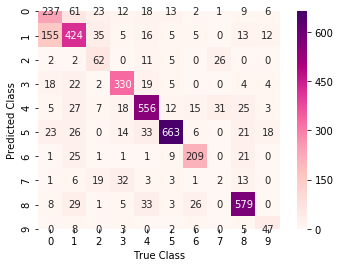

on train:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1410
         1.0       0.97      0.95      0.96      1860
         2.0       0.92      1.00      0.96       420
         3.0       0.96      0.98      0.97      1320
         4.0       0.99      0.97      0.98      2100
         5.0       0.99      0.98      0.98      2160
         6.0       0.98      0.99      0.99       780
         7.0       0.90      1.00      0.95       240
         8.0       0.99      0.98      0.98      2070
         9.0       0.96      1.00      0.98       300

    accuracy                           0.97     12660
   macro avg       0.96      0.98      0.97     12660
weighted avg       0.97      0.97      0.97     12660


 
 

next model, with min node = 5
on test:
               precision    recall  f1-score   support

         0.0       0.63      0.53      0.57       450
         1.0       0.61      0.67      0.64       630
         2.0       0.

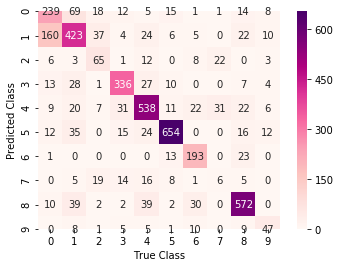

on train:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1410
         1.0       0.95      0.92      0.93      1860
         2.0       0.88      0.98      0.93       420
         3.0       0.95      0.96      0.96      1320
         4.0       0.97      0.95      0.96      2100
         5.0       0.98      0.95      0.97      2160
         6.0       0.99      0.98      0.98       780
         7.0       0.81      1.00      0.89       240
         8.0       0.98      0.97      0.97      2070
         9.0       0.87      1.00      0.93       300

    accuracy                           0.95     12660
   macro avg       0.93      0.96      0.94     12660
weighted avg       0.95      0.95      0.95     12660


 
 

next model, with min node = 7
on test:
               precision    recall  f1-score   support

         0.0       0.60      0.54      0.57       450
         1.0       0.62      0.65      0.63       630
         2.0       0.

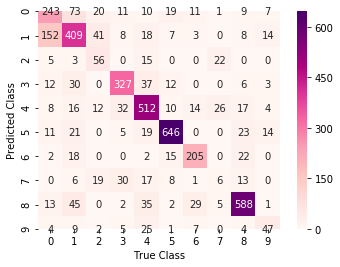

on train:
               precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1410
         1.0       0.94      0.89      0.91      1860
         2.0       0.87      0.97      0.92       420
         3.0       0.95      0.96      0.95      1320
         4.0       0.96      0.93      0.95      2100
         5.0       0.97      0.94      0.96      2160
         6.0       0.95      0.98      0.96       780
         7.0       0.75      0.99      0.85       240
         8.0       0.97      0.96      0.97      2070
         9.0       0.83      1.00      0.90       300

    accuracy                           0.94     12660
   macro avg       0.91      0.95      0.93     12660
weighted avg       0.94      0.94      0.94     12660


 
 

next model, with min node = 9
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.56      0.61       450
         1.0       0.63      0.69      0.66       630
         2.0       0.

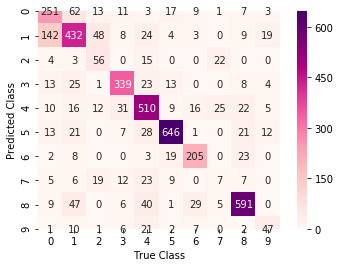

on train:
               precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1410
         1.0       0.93      0.88      0.90      1860
         2.0       0.87      0.96      0.92       420
         3.0       0.95      0.94      0.95      1320
         4.0       0.95      0.92      0.94      2100
         5.0       0.97      0.93      0.95      2160
         6.0       0.93      0.98      0.95       780
         7.0       0.72      0.98      0.83       240
         8.0       0.97      0.95      0.96      2070
         9.0       0.80      0.99      0.88       300

    accuracy                           0.93     12660
   macro avg       0.90      0.95      0.92     12660
weighted avg       0.93      0.93      0.93     12660


 
 

next model, with min node = 11
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.59      0.61       450
         1.0       0.62      0.65      0.64       630
         2.0       0

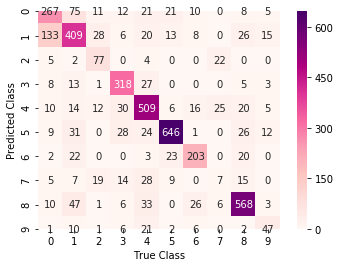

on train:
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      1410
         1.0       0.91      0.87      0.89      1860
         2.0       0.94      0.95      0.94       420
         3.0       0.95      0.93      0.94      1320
         4.0       0.95      0.90      0.93      2100
         5.0       0.96      0.93      0.94      2160
         6.0       0.91      0.98      0.95       780
         7.0       0.66      0.98      0.79       240
         8.0       0.98      0.94      0.96      2070
         9.0       0.79      0.99      0.88       300

    accuracy                           0.92     12660
   macro avg       0.89      0.94      0.91     12660
weighted avg       0.93      0.92      0.92     12660


 
 

next model, with min node = 13
on test:
               precision    recall  f1-score   support

         0.0       0.69      0.57      0.62       450
         1.0       0.62      0.64      0.63       630
         2.0       0

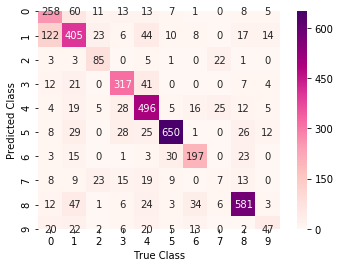

on train:
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1410
         1.0       0.91      0.85      0.88      1860
         2.0       0.84      0.96      0.90       420
         3.0       0.95      0.93      0.94      1320
         4.0       0.96      0.89      0.92      2100
         5.0       0.96      0.92      0.94      2160
         6.0       0.91      0.98      0.94       780
         7.0       0.68      0.97      0.80       240
         8.0       0.95      0.94      0.95      2070
         9.0       0.72      0.99      0.83       300

    accuracy                           0.91     12660
   macro avg       0.87      0.93      0.90     12660
weighted avg       0.92      0.91      0.91     12660


 
 

next model, with min node = 15
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.57      0.62       450
         1.0       0.63      0.66      0.65       630
         2.0       0

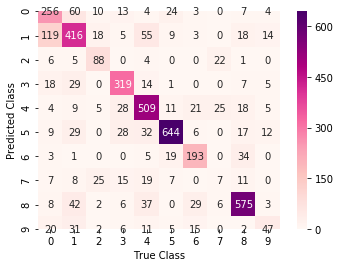

on train:
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1410
         1.0       0.91      0.84      0.87      1860
         2.0       0.79      0.96      0.87       420
         3.0       0.93      0.92      0.93      1320
         4.0       0.94      0.90      0.92      2100
         5.0       0.96      0.92      0.94      2160
         6.0       0.91      0.97      0.94       780
         7.0       0.72      0.96      0.82       240
         8.0       0.95      0.93      0.94      2070
         9.0       0.72      0.99      0.84       300

    accuracy                           0.91     12660
   macro avg       0.87      0.92      0.89     12660
weighted avg       0.91      0.91      0.91     12660


 
 

next model, with min node = 17
on test:
               precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       450
         1.0       0.64      0.66      0.65       630
         2.0       0

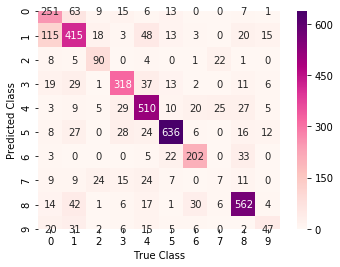

on train:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84      1410
         1.0       0.90      0.83      0.86      1860
         2.0       0.79      0.96      0.86       420
         3.0       0.91      0.92      0.91      1320
         4.0       0.93      0.89      0.91      2100
         5.0       0.96      0.90      0.93      2160
         6.0       0.90      0.96      0.93       780
         7.0       0.69      0.96      0.81       240
         8.0       0.95      0.92      0.94      2070
         9.0       0.72      0.99      0.83       300

    accuracy                           0.90     12660
   macro avg       0.86      0.92      0.88     12660
weighted avg       0.90      0.90      0.90     12660


 
 

next model, with min node = 19
on test:
               precision    recall  f1-score   support

         0.0       0.68      0.60      0.64       450
         1.0       0.63      0.65      0.64       630
         2.0       0

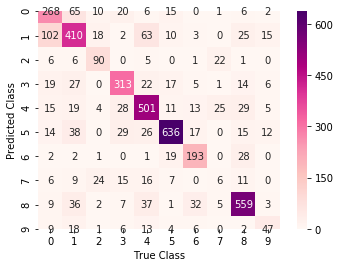

on train:
               precision    recall  f1-score   support

         0.0       0.80      0.83      0.81      1410
         1.0       0.87      0.83      0.85      1860
         2.0       0.77      0.96      0.85       420
         3.0       0.89      0.91      0.90      1320
         4.0       0.93      0.87      0.90      2100
         5.0       0.95      0.90      0.92      2160
         6.0       0.92      0.96      0.94       780
         7.0       0.68      0.95      0.79       240
         8.0       0.95      0.91      0.93      2070
         9.0       0.73      0.98      0.84       300

    accuracy                           0.89     12660
   macro avg       0.85      0.91      0.87     12660
weighted avg       0.89      0.89      0.89     12660



In [26]:
#now show results
i = 1
for clf_smpl_splt in clf_list3:
    #predict on test and training data
    y_pred_test_data_splt = clf_smpl_splt.predict(x_test)
    y_pred_train_data_splt = clf_smpl_splt.predict(x_train)
    # results on test close to results without limit
    print("\n \n \n")
    print("next model, with min node =",i)
    print("on test:\n",classification_report(y_test, y_pred_test_data_splt))
    conf_mat = confusion_matrix(y_test, y_pred_test_data_splt)
    sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class');
    plt.show()
    #shows overfitting
    print("on train:\n",classification_report(y_train, y_pred_train_data_splt))
    i +=2

##### using min_samples_leaf

In [27]:
#try and limit overfitting a different way
# using min_samples_leaf

#loop through and try different values
clf_list4 = []
split = (0.004,0.002, 0.001, 0.0008,0.0006,0.0004,0.0002)
for x in split:
    clf_smpl_splt = tree.DecisionTreeClassifier(class_weight = "balanced", min_impurity_decrease = x)
    clf_smpl_splt.fit(x_train, y_train)
    graph = graphviz.Source(tree.export_graphviz(clf_smpl_splt, out_file=None,filled=True,rounded=True,class_names=True)) 
    clf_list4.append( clf_smpl_splt)
    
    png_bytes = graph.pipe(format='png')  
    name = "overfitting_tree_imp_"+str(x)+ ".png"
    with open(name,'wb') as f:
        f.write(png_bytes)
    


#Image("overfitting_tree_imp_"+str(0.001)+ ".png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.899303 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.746282 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.578851 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.370827 to fit



 
 

next model, with min imp = 0.004
on test:
               precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       450
         1.0       0.51      0.54      0.52       630
         2.0       0.33      0.39      0.36       150
         3.0       0.73      0.76      0.75       420
         4.0       0.64      0.63      0.63       690
         5.0       0.80      0.88      0.83       720
         6.0       0.73      0.53      0.61       270
         7.0       0.01      0.02      0.01        60
         8.0       0.77      0.63      0.69       690
         9.0       0.35      0.53      0.42        90

    accuracy                           0.63      4170
   macro avg       0.54      0.54      0.53      4170
weighted avg       0.64      0.63      0.63      4170



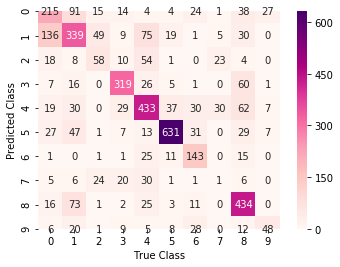

on train:
               precision    recall  f1-score   support

         0.0       0.52      0.63      0.57      1410
         1.0       0.58      0.58      0.58      1860
         2.0       0.45      0.88      0.60       420
         3.0       0.85      0.76      0.80      1320
         4.0       0.77      0.68      0.72      2100
         5.0       0.87      0.83      0.85      2160
         6.0       0.80      0.82      0.81       780
         7.0       0.65      0.88      0.74       240
         8.0       0.86      0.67      0.75      2070
         9.0       0.68      0.94      0.79       300

    accuracy                           0.72     12660
   macro avg       0.70      0.77      0.72     12660
weighted avg       0.74      0.72      0.72     12660


 
 

next model, with min imp = 0.002
on test:
               precision    recall  f1-score   support

         0.0       0.55      0.54      0.55       450
         1.0       0.61      0.64      0.62       630
         2.0      

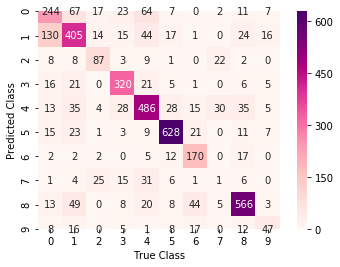

on train:
               precision    recall  f1-score   support

         0.0       0.65      0.78      0.71      1410
         1.0       0.72      0.70      0.71      1860
         2.0       0.70      0.92      0.79       420
         3.0       0.86      0.83      0.85      1320
         4.0       0.85      0.79      0.82      2100
         5.0       0.95      0.82      0.88      2160
         6.0       0.92      0.94      0.93       780
         7.0       0.73      0.93      0.82       240
         8.0       0.87      0.85      0.86      2070
         9.0       0.78      0.95      0.86       300

    accuracy                           0.82     12660
   macro avg       0.80      0.85      0.82     12660
weighted avg       0.83      0.82      0.82     12660


 
 

next model, with min imp = 0.001
on test:
               precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       450
         1.0       0.59      0.65      0.62       630
         2.0      

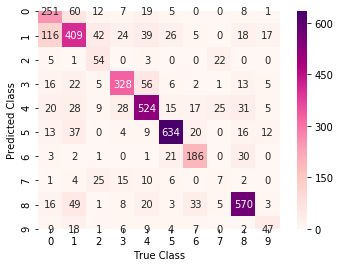

on train:
               precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      1410
         1.0       0.80      0.78      0.79      1860
         2.0       0.90      0.95      0.93       420
         3.0       0.88      0.91      0.90      1320
         4.0       0.90      0.88      0.89      2100
         5.0       0.96      0.87      0.91      2160
         6.0       0.89      0.96      0.93       780
         7.0       0.82      0.96      0.88       240
         8.0       0.91      0.90      0.91      2070
         9.0       0.76      0.98      0.86       300

    accuracy                           0.87     12660
   macro avg       0.86      0.90      0.88     12660
weighted avg       0.88      0.87      0.87     12660


 
 

next model, with min imp = 0.0008
on test:
               precision    recall  f1-score   support

         0.0       0.75      0.56      0.64       450
         1.0       0.55      0.64      0.59       630
         2.0     

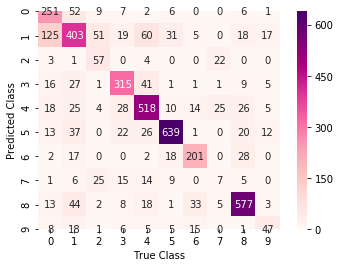

on train:
               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      1410
         1.0       0.81      0.83      0.82      1860
         2.0       0.92      0.97      0.94       420
         3.0       0.90      0.92      0.91      1320
         4.0       0.92      0.89      0.91      2100
         5.0       0.96      0.88      0.92      2160
         6.0       0.93      0.97      0.95       780
         7.0       0.77      0.98      0.86       240
         8.0       0.93      0.94      0.93      2070
         9.0       0.82      0.99      0.90       300

    accuracy                           0.89     12660
   macro avg       0.88      0.92      0.90     12660
weighted avg       0.90      0.89      0.89     12660


 
 

next model, with min imp = 0.0006
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.56      0.61       450
         1.0       0.59      0.68      0.63       630
         2.0     

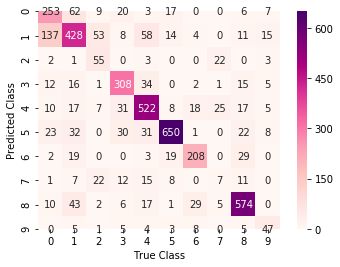

on train:
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1410
         1.0       0.86      0.86      0.86      1860
         2.0       0.94      0.97      0.96       420
         3.0       0.93      0.93      0.93      1320
         4.0       0.94      0.91      0.92      2100
         5.0       0.95      0.92      0.94      2160
         6.0       0.91      0.98      0.94       780
         7.0       0.83      0.99      0.90       240
         8.0       0.96      0.93      0.95      2070
         9.0       0.89      0.99      0.94       300

    accuracy                           0.91     12660
   macro avg       0.90      0.93      0.92     12660
weighted avg       0.92      0.91      0.91     12660


 
 

next model, with min imp = 0.0004
on test:
               precision    recall  f1-score   support

         0.0       0.68      0.57      0.62       450
         1.0       0.62      0.67      0.64       630
         2.0     

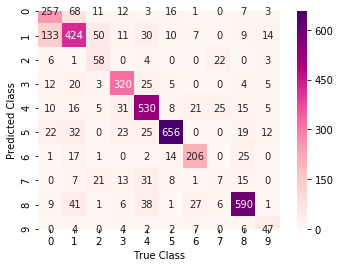

on train:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1410
         1.0       0.92      0.89      0.90      1860
         2.0       0.92      0.99      0.95       420
         3.0       0.95      0.95      0.95      1320
         4.0       0.96      0.92      0.94      2100
         5.0       0.96      0.94      0.95      2160
         6.0       0.96      0.98      0.97       780
         7.0       0.76      1.00      0.86       240
         8.0       0.97      0.96      0.96      2070
         9.0       0.94      1.00      0.97       300

    accuracy                           0.94     12660
   macro avg       0.92      0.95      0.93     12660
weighted avg       0.94      0.94      0.94     12660


 
 

next model, with min imp = 0.0002
on test:
               precision    recall  f1-score   support

         0.0       0.62      0.51      0.56       450
         1.0       0.61      0.68      0.64       630
         2.0     

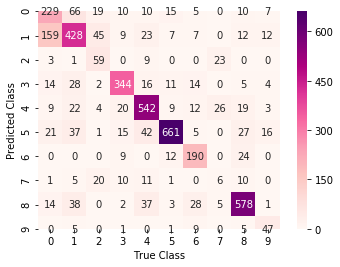

on train:
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1410
         1.0       0.97      0.94      0.95      1860
         2.0       0.95      1.00      0.98       420
         3.0       0.96      0.97      0.97      1320
         4.0       0.97      0.96      0.97      2100
         5.0       0.98      0.98      0.98      2160
         6.0       0.99      0.99      0.99       780
         7.0       0.98      1.00      0.99       240
         8.0       0.98      0.97      0.98      2070
         9.0       0.97      1.00      0.99       300

    accuracy                           0.97     12660
   macro avg       0.97      0.98      0.97     12660
weighted avg       0.97      0.97      0.97     12660



In [28]:
#now show results
i = 0
for clf_smpl_splt in clf_list4:
    #predict on test and training data 
    y_pred_test_data_splt = clf_smpl_splt.predict(x_test)
    y_pred_train_data_splt = clf_smpl_splt.predict(x_train)
    # results on test close to results without limit
    print("\n \n \n")
    print("next model, with min imp =",split[i])
    print("on test:\n",classification_report(y_test, y_pred_test_data_splt))
    conf_mat = confusion_matrix(y_test, y_pred_test_data_splt)
    sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class');
    plt.show()
    #shows overfitting
    print("on train:\n",classification_report(y_train, y_pred_train_data_splt))
    i +=1

##### using min_weight_fraction_leaf

In [29]:
#try and limit overfitting a different way
# using min_weight_fraction_leaf

#loop through and try different values
clf_list5 = []
split = (0.002, 0.001, 0.0008, 0.0006, 0.0004, 0.0002)
for x in split:
    clf_smpl_splt = tree.DecisionTreeClassifier(class_weight = "balanced",min_weight_fraction_leaf = x)
    clf_smpl_splt.fit(x_train, y_train)
    graph = graphviz.Source(tree.export_graphviz(clf_smpl_splt, out_file=None,filled=True,rounded=True,class_names=True)) 
    clf_list5.append( clf_smpl_splt)
    
    png_bytes = graph.pipe(format='png')  
    name = "overfitting_tree_minweight_"+str(x)+ ".png"
    with open(name,'wb') as f:
        f.write(png_bytes)
    


#Image("overfitting_tree_minweight_"+str(0.0002)+ ".png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.699656 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.503589 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.439342 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.406821 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.345815 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.297782 to fit



 
 

next model, with min weight = 0.002
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.55      0.60       450
         1.0       0.62      0.68      0.65       630
         2.0       0.64      0.41      0.50       150
         3.0       0.79      0.78      0.78       420
         4.0       0.73      0.75      0.74       690
         5.0       0.84      0.89      0.87       720
         6.0       0.82      0.66      0.74       270
         7.0       0.10      0.10      0.10        60
         8.0       0.79      0.83      0.81       690
         9.0       0.36      0.52      0.43        90

    accuracy                           0.72      4170
   macro avg       0.64      0.62      0.62      4170
weighted avg       0.73      0.72      0.72      4170



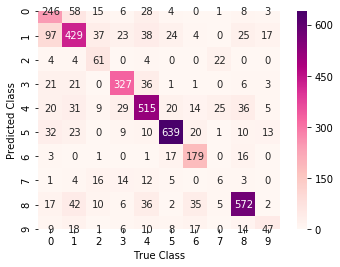

on train:
               precision    recall  f1-score   support

         0.0       0.77      0.80      0.79      1410
         1.0       0.79      0.79      0.79      1860
         2.0       0.83      0.94      0.88       420
         3.0       0.89      0.89      0.89      1320
         4.0       0.89      0.86      0.88      2100
         5.0       0.95      0.87      0.91      2160
         6.0       0.92      0.95      0.93       780
         7.0       0.86      0.94      0.90       240
         8.0       0.91      0.90      0.91      2070
         9.0       0.68      0.98      0.80       300

    accuracy                           0.87     12660
   macro avg       0.85      0.89      0.87     12660
weighted avg       0.87      0.87      0.87     12660


 
 

next model, with min weight = 0.001
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.60      0.64       450
         1.0       0.63      0.67      0.65       630
         2.0   

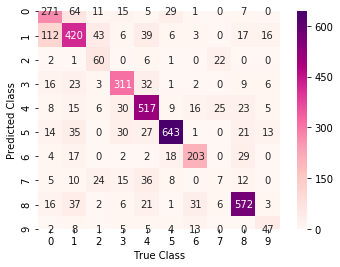

on train:
               precision    recall  f1-score   support

         0.0       0.82      0.85      0.84      1410
         1.0       0.89      0.85      0.87      1860
         2.0       0.90      0.96      0.93       420
         3.0       0.93      0.93      0.93      1320
         4.0       0.93      0.90      0.91      2100
         5.0       0.95      0.91      0.93      2160
         6.0       0.91      0.98      0.95       780
         7.0       0.71      0.98      0.83       240
         8.0       0.95      0.93      0.94      2070
         9.0       0.87      0.99      0.93       300

    accuracy                           0.91     12660
   macro avg       0.89      0.93      0.90     12660
weighted avg       0.91      0.91      0.91     12660


 
 

next model, with min weight = 0.0008
on test:
               precision    recall  f1-score   support

         0.0       0.67      0.58      0.62       450
         1.0       0.60      0.66      0.63       630
         2.0  

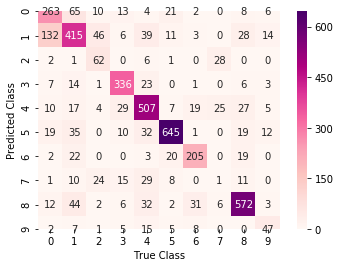

on train:
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      1410
         1.0       0.90      0.86      0.88      1860
         2.0       0.91      0.97      0.94       420
         3.0       0.96      0.93      0.94      1320
         4.0       0.94      0.90      0.92      2100
         5.0       0.94      0.92      0.93      2160
         6.0       0.92      0.98      0.95       780
         7.0       0.78      0.97      0.87       240
         8.0       0.94      0.94      0.94      2070
         9.0       0.84      0.99      0.91       300

    accuracy                           0.92     12660
   macro avg       0.90      0.94      0.91     12660
weighted avg       0.92      0.92      0.92     12660


 
 

next model, with min weight = 0.0006
on test:
               precision    recall  f1-score   support

         0.0       0.65      0.58      0.61       450
         1.0       0.61      0.67      0.64       630
         2.0  

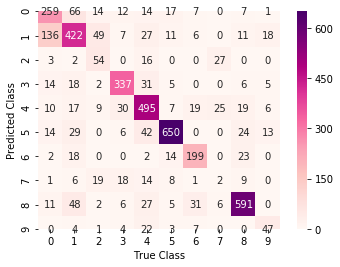

on train:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.88      1410
         1.0       0.91      0.86      0.88      1860
         2.0       0.88      0.98      0.93       420
         3.0       0.95      0.94      0.95      1320
         4.0       0.95      0.91      0.93      2100
         5.0       0.95      0.94      0.94      2160
         6.0       0.95      0.98      0.97       780
         7.0       0.77      0.99      0.86       240
         8.0       0.97      0.95      0.96      2070
         9.0       0.87      1.00      0.93       300

    accuracy                           0.93     12660
   macro avg       0.91      0.95      0.92     12660
weighted avg       0.93      0.93      0.93     12660


 
 

next model, with min weight = 0.0004
on test:
               precision    recall  f1-score   support

         0.0       0.60      0.52      0.56       450
         1.0       0.62      0.65      0.63       630
         2.0  

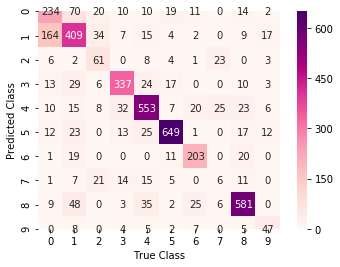

on train:
               precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      1410
         1.0       0.93      0.91      0.92      1860
         2.0       0.90      1.00      0.95       420
         3.0       0.93      0.96      0.95      1320
         4.0       0.94      0.94      0.94      2100
         5.0       0.98      0.94      0.96      2160
         6.0       0.97      0.98      0.98       780
         7.0       0.91      1.00      0.95       240
         8.0       0.97      0.96      0.96      2070
         9.0       0.94      1.00      0.97       300

    accuracy                           0.94     12660
   macro avg       0.94      0.96      0.95     12660
weighted avg       0.94      0.94      0.94     12660


 
 

next model, with min weight = 0.0002
on test:
               precision    recall  f1-score   support

         0.0       0.61      0.52      0.56       450
         1.0       0.62      0.69      0.65       630
         2.0  

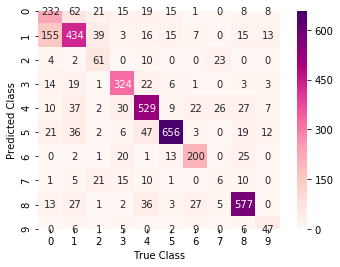

on train:
               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1410
         1.0       0.96      0.94      0.95      1860
         2.0       0.95      1.00      0.98       420
         3.0       0.96      0.97      0.97      1320
         4.0       0.97      0.96      0.96      2100
         5.0       0.98      0.97      0.97      2160
         6.0       0.98      0.99      0.99       780
         7.0       0.97      1.00      0.98       240
         8.0       0.98      0.97      0.98      2070
         9.0       0.95      1.00      0.98       300

    accuracy                           0.97     12660
   macro avg       0.96      0.98      0.97     12660
weighted avg       0.97      0.97      0.97     12660



In [30]:
#now show results
i = 0
for clf_smpl_splt in clf_list5:
    #predict on test and training data again
    y_pred_test_data_splt = clf_smpl_splt.predict(x_test)
    y_pred_train_data_splt = clf_smpl_splt.predict(x_train)
    # results on test close to results without limit
    print("\n \n \n")
    print("next model, with min weight =",split[i])
    print("on test:\n",classification_report(y_test, y_pred_test_data_splt))
    conf_mat = confusion_matrix(y_test, y_pred_test_data_splt)
    sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class');
    plt.show()
    #shows overfitting
    print("on train:\n",classification_report(y_train, y_pred_train_data_splt))
    i +=1

### results from reducing overfitting - combine all best parameters

In [31]:
clf2 = tree.DecisionTreeClassifier(class_weight = "balanced",min_weight_fraction_leaf = 0.0004, max_depth = 11 ,min_samples_leaf = 3, min_impurity_decrease = 0.0004)
clf2.fit(x_train, y_train)

graph = graphviz.Source(tree.export_graphviz(clf2, out_file=None,filled=True,rounded=True,class_names=True)) 
png_bytes = graph.pipe(format='png')  
name = "tree_all.png"
with open(name,'wb') as f:
    f.write(png_bytes)

#Image(name)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.675038 to fit


              precision    recall  f1-score   support

         0.0       0.70      0.57      0.63       450
         1.0       0.60      0.71      0.65       630
         2.0       0.62      0.37      0.47       150
         3.0       0.83      0.74      0.78       420
         4.0       0.80      0.79      0.79       690
         5.0       0.87      0.90      0.88       720
         6.0       0.79      0.69      0.74       270
         7.0       0.04      0.07      0.05        60
         8.0       0.79      0.85      0.82       690
         9.0       0.57      0.52      0.55        90

    accuracy                           0.74      4170
   macro avg       0.66      0.62      0.64      4170
weighted avg       0.75      0.74      0.74      4170



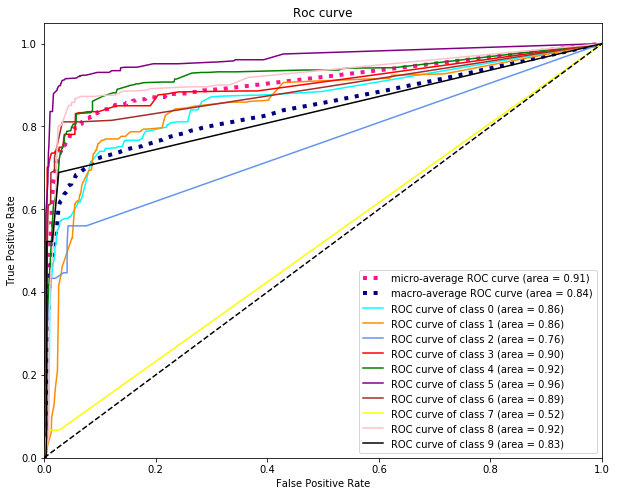

In [32]:
#use model to predict for test set
y_pred_test = clf2.predict(x_test)
y_score = clf2.predict_proba(x_test)
print(classification_report(y_test, y_pred_test))
rocCurve(y_test, y_score)

In [33]:
#use model to predict train set
y_pred_train = clf2.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1410
         1.0       0.82      0.87      0.84      1860
         2.0       0.91      0.97      0.94       420
         3.0       0.94      0.93      0.93      1320
         4.0       0.94      0.90      0.92      2100
         5.0       0.96      0.90      0.93      2160
         6.0       0.95      0.97      0.96       780
         7.0       0.76      0.99      0.86       240
         8.0       0.94      0.94      0.94      2070
         9.0       0.94      0.98      0.96       300

    accuracy                           0.91     12660
   macro avg       0.90      0.93      0.91     12660
weighted avg       0.91      0.91      0.91     12660



### Run with Q6 test Data

In [34]:
#now train with smaller data set for q6 and larger test set
clf2 = tree.DecisionTreeClassifier(class_weight = "balanced",min_weight_fraction_leaf = 0.0002, max_depth = 14,min_samples_leaf = 2, min_impurity_decrease = 0.0002)
clf2.fit(x_train_q6, y_train_q6)
y_score = clf2.predict_proba(x_test_q6)
graph = graphviz.Source(tree.export_graphviz(clf2, out_file=None,filled=True,rounded=True,class_names=True)) 
png_bytes = graph.pipe(format='png')  
name = "tree.png"
with open(name,'wb') as f:
    f.write(png_bytes)

#Image(name)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.471447 to fit


              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68       873
         1.0       0.71      0.70      0.71      1188
         2.0       0.65      0.63      0.64       276
         3.0       0.86      0.86      0.86       816
         4.0       0.82      0.81      0.82      1320
         5.0       0.87      0.93      0.90      1368
         6.0       0.80      0.83      0.82       504
         7.0       0.51      0.42      0.46       132
         8.0       0.87      0.80      0.83      1311
         9.0       0.73      0.73      0.73       180

    accuracy                           0.79      7968
   macro avg       0.75      0.74      0.74      7968
weighted avg       0.79      0.79      0.79      7968



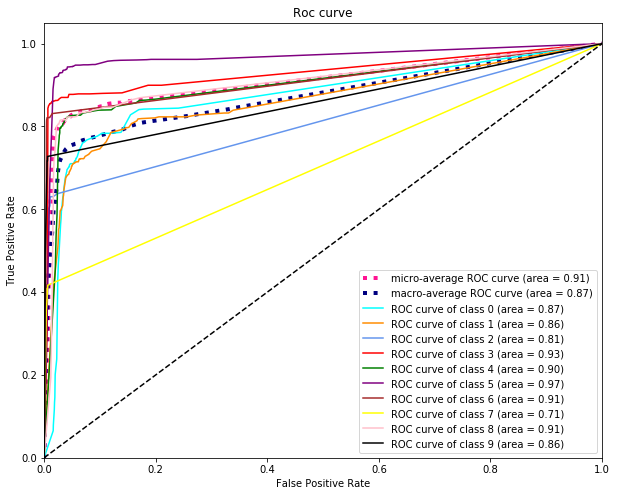

In [35]:
#use model to predict for test set
y_pred_test_q6 = clf2.predict(x_test_q6)
print(classification_report(y_test_q6, y_pred_test_q6))
rocCurve(y_test_q6, y_score)

In [36]:
#to check overfitting - predict train set
y_pred_train_q6 = clf2.predict(x_train_q6)
print(classification_report(y_train_q6, y_pred_train_q6))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       987
         1.0       0.93      0.92      0.93      1302
         2.0       0.92      0.99      0.96       294
         3.0       0.96      0.96      0.96       924
         4.0       0.97      0.95      0.96      1470
         5.0       0.98      0.95      0.96      1512
         6.0       0.94      0.99      0.97       546
         7.0       0.92      1.00      0.96       168
         8.0       0.97      0.96      0.97      1449
         9.0       0.92      1.00      0.96       210

    accuracy                           0.95      8862
   macro avg       0.94      0.97      0.95      8862
weighted avg       0.95      0.95      0.95      8862



### Run with Q7 data

In [37]:
#now train with smaller data set for q7 and larger test set
clf_q7 = tree.DecisionTreeClassifier(class_weight = "balanced",min_weight_fraction_leaf = 0.0002, max_depth = 14,min_samples_leaf = 2, min_impurity_decrease = 0.0002)
clf_q7.fit(x_train_q7, y_train_q7)
graph = graphviz.Source(tree.export_graphviz(clf_q7, out_file=None,filled=True,rounded=True,class_names=True)) 
png_bytes = graph.pipe(format='png')  
name = "tree.png"
with open(name,'wb') as f:
    f.write(png_bytes)

#Image(name)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.658091 to fit


In [38]:
#use model to predict for test set
y_pred_test_q7 = clf_q7.predict(x_test_q7)
print(classification_report(y_test_q7, y_pred_test_q7))

              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66      1437
         1.0       0.61      0.69      0.65      1932
         2.0       0.69      0.68      0.68       444
         3.0       0.88      0.82      0.85      1344
         4.0       0.77      0.74      0.76      2160
         5.0       0.85      0.86      0.86      2232
         6.0       0.76      0.79      0.78       816
         7.0       0.43      0.58      0.49       228
         8.0       0.85      0.83      0.84      2139
         9.0       0.71      0.68      0.70       300

    accuracy                           0.76     13032
   macro avg       0.73      0.73      0.73     13032
weighted avg       0.77      0.76      0.76     13032



In [39]:
#to check overfitting - predict train set
y_pred_train_q7 = clf2.predict(x_train_q7)
print(classification_report(y_train_q7, y_pred_train_q7))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       423
         1.0       0.90      0.90      0.90       558
         2.0       0.88      0.96      0.92       126
         3.0       0.96      0.95      0.96       396
         4.0       0.96      0.94      0.95       630
         5.0       0.98      0.95      0.96       648
         6.0       0.93      0.98      0.95       234
         7.0       0.87      0.92      0.89        72
         8.0       0.96      0.94      0.95       621
         9.0       0.94      0.97      0.95        90

    accuracy                           0.94      3798
   macro avg       0.92      0.94      0.93      3798
weighted avg       0.94      0.94      0.94      3798



## reducing train size keeping test set constant

In [40]:
#to see how reducing train size effect results
test_size = (0.1,  0.3,  0.5, 0.7,  0.9, 0.95, 0.99)

for x in test_size:
    x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_train, y_train, test_size=x, stratify=y_train)
    clf = tree.DecisionTreeClassifier(class_weight = "balanced")
    clf.fit(x_train_r, y_train_r)
    y_pred = clf.predict(x_test)
    print("on test ("+ str(x) +"):\n",classification_report(y_test, y_pred))


on test (0.1):
               precision    recall  f1-score   support

         0.0       0.63      0.61      0.62       450
         1.0       0.64      0.64      0.64       630
         2.0       0.59      0.45      0.51       150
         3.0       0.86      0.82      0.84       420
         4.0       0.72      0.78      0.75       690
         5.0       0.85      0.92      0.88       720
         6.0       0.82      0.74      0.78       270
         7.0       0.03      0.02      0.02        60
         8.0       0.82      0.84      0.83       690
         9.0       0.62      0.51      0.56        90

    accuracy                           0.75      4170
   macro avg       0.66      0.63      0.64      4170
weighted avg       0.74      0.75      0.74      4170

on test (0.3):
               precision    recall  f1-score   support

         0.0       0.63      0.56      0.60       450
         1.0       0.58      0.57      0.57       630
         2.0       0.55      0.45      0.49   

## Random Forest

In [41]:
# 100 trees - no limit to overfitting
rnd_forest = RandomForestClassifier(n_estimators = 100)
rnd_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

         0.0       0.79      0.59      0.68       450
         1.0       0.69      0.89      0.78       630
         2.0       0.81      0.53      0.64       150
         3.0       0.99      0.95      0.97       420
         4.0       0.87      0.93      0.90       690
         5.0       0.97      0.99      0.98       720
         6.0       0.97      0.92      0.94       270
         7.0       0.37      0.18      0.24        60
         8.0       0.95      0.97      0.96       690
         9.0       1.00      0.66      0.79        90

    accuracy                           0.88      4170
   macro avg       0.84      0.76      0.79      4170
weighted avg       0.88      0.88      0.87      4170



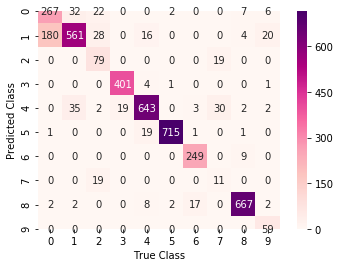

In [42]:
#now predict on test set using random tree model
y_pred_rf = rnd_forest.predict(x_test)
print(classification_report(y_test, y_pred_rf))
conf_mat = confusion_matrix(y_test,  y_pred_rf)
sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
plt.xlabel('True Class')
plt.ylabel('Predicted Class');
plt.show()

#### With limits to overfitting

In [43]:
#random tree with limits to overfitting
rnd_forest = RandomForestClassifier(n_estimators = 100,class_weight = "balanced",min_weight_fraction_leaf = 0.0002, max_depth = 14,min_samples_leaf = 2, min_impurity_decrease = 0.0002)
rnd_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0002,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [44]:
y_pred_rf = rnd_forest.predict(x_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68       450
         1.0       0.68      0.80      0.74       630
         2.0       0.76      0.51      0.61       150
         3.0       0.98      0.95      0.96       420
         4.0       0.81      0.90      0.85       690
         5.0       0.97      0.99      0.98       720
         6.0       0.98      0.92      0.95       270
         7.0       0.18      0.10      0.13        60
         8.0       0.95      0.97      0.96       690
         9.0       1.00      0.67      0.80        90

    accuracy                           0.86      4170
   macro avg       0.81      0.74      0.77      4170
weighted avg       0.86      0.86      0.85      4170



In [45]:
y_pred_rf = rnd_forest.predict(x_train)
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1410
         1.0       1.00      1.00      1.00      1860
         2.0       1.00      1.00      1.00       420
         3.0       1.00      1.00      1.00      1320
         4.0       1.00      1.00      1.00      2100
         5.0       1.00      1.00      1.00      2160
         6.0       1.00      1.00      1.00       780
         7.0       0.99      1.00      1.00       240
         8.0       1.00      1.00      1.00      2070
         9.0       1.00      1.00      1.00       300

    accuracy                           1.00     12660
   macro avg       1.00      1.00      1.00     12660
weighted avg       1.00      1.00      1.00     12660



## Try with standardised data - research question

              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74       450
         1.0       0.76      0.94      0.84       630
         2.0       1.00      0.71      0.83       150
         3.0       0.98      0.98      0.98       420
         4.0       0.95      0.98      0.96       690
         5.0       0.99      0.99      0.99       720
         6.0       0.99      0.96      0.97       270
         7.0       0.95      0.95      0.95        60
         8.0       0.96      0.96      0.96       690
         9.0       1.00      0.89      0.94        90

    accuracy                           0.92      4170
   macro avg       0.94      0.90      0.92      4170
weighted avg       0.93      0.92      0.92      4170



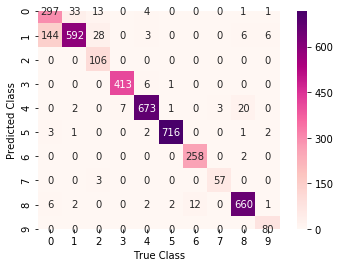

In [46]:
# uses standardised data (see preprocessing at top)
#use random forest
rnd_forest = RandomForestClassifier(n_estimators = 100)
rnd_forest.fit(x_train_stan, y_train)
y_pred_rf = rnd_forest.predict(x_test_stan)
print(classification_report(y_test, y_pred_rf))
conf_mat = confusion_matrix(y_test,  y_pred_rf)
sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
plt.xlabel('True Class')
plt.ylabel('Predicted Class');
plt.show()



In [47]:
#use tree classifier
clf2 = tree.DecisionTreeClassifier(class_weight = "balanced")
clf2.fit(x_train_stan, y_train)

graph = graphviz.Source(tree.export_graphviz(clf2, out_file=None,filled=True,rounded=True,class_names=True)) 
png_bytes = graph.pipe(format='png')  
name = "tree.png"
with open(name,'wb') as f:
    f.write(png_bytes)

#Image(name)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.260751 to fit


              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67       450
         1.0       0.68      0.77      0.72       630
         2.0       0.72      0.67      0.70       150
         3.0       0.88      0.79      0.83       420
         4.0       0.82      0.79      0.80       690
         5.0       0.91      0.93      0.92       720
         6.0       0.94      0.81      0.87       270
         7.0       0.75      0.88      0.81        60
         8.0       0.86      0.80      0.83       690
         9.0       0.87      0.76      0.81        90

    accuracy                           0.80      4170
   macro avg       0.80      0.79      0.80      4170
weighted avg       0.81      0.80      0.80      4170



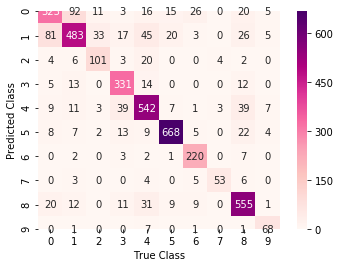

In [48]:
#use model to predict for test set
y_pred_test = clf2.predict(x_test_stan)
print(classification_report(y_test, y_pred_test))
conf_mat = confusion_matrix(y_test,  y_pred_test)
sns.heatmap(conf_mat.T, square=True, annot=True,cmap="RdPu", fmt='.0f', cbar=True)
plt.xlabel('True Class')
plt.ylabel('Predicted Class');
plt.show()

## roc curve code

In [ ]:
rocCurve(y_test, y_score)

In [51]:
def rocCurve(y_test, y_score):
    y_test_b = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
    #print(y_test_b)
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    n_classes = 10
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'yellow', 'pink', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve')
    plt.legend(loc="lower right")
    plt.show()